In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

There are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
# !pip install transformers
# !pip install seaborn

Importing Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
from sklearn.metrics import matthews_corrcoef, accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample

In [ ]:
Stres_Data = pd.read_csv("Stress.csv")
Stres_Data.shape

(2838, 7)

In [ ]:
Stres_Data.sample(5)

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
2002,domesticviolence,5zjmqv,"[0, 5]","Hi everyone, So I am in abusive relationship. ...",0,0.600000,1489587889
1887,homeless,6mpnb0,"[32, 37]",The weird feeling hasn't gone away; but I feel...,0,0.833333,1499811121
2204,domesticviolence,8pww89,"(45, 50)",He ended up grabbing me by the neck with both ...,1,0.800000,1528587735
1357,anxiety,95ij0n,"(0, 5)",i probably havesevere gad. at least i think i ...,1,0.800000,1533699068
2310,relationships,7q2msh,"[10, 15]",1) His career/financial stability (makes sense...,0,0.571429,1515820825


In [ ]:
Stres_Data = Stres_Data[Stres_Data['label'] != 0.6]
Stres_Data.shape

(2838, 7)

EDA

Text(0, 0.5, 'samples')

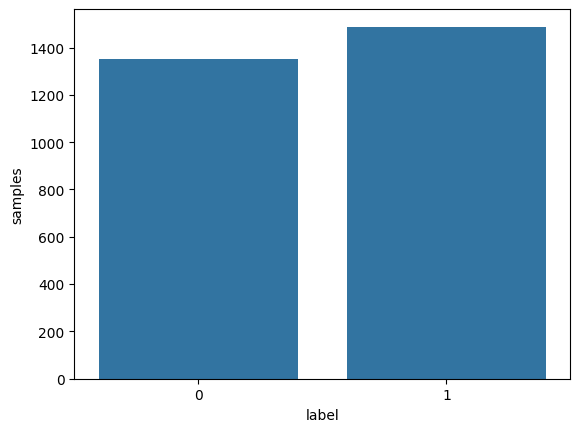

In [ ]:
X = Stres_Data['label'].value_counts()
sns.barplot(X)
plt.gca().set_ylabel('samples')

In [ ]:
print(X)

label
1    1488
0    1350
Name: count, dtype: int64


Data Imbalance Upsampling the dataset

In [ ]:
One_Sample = Stres_Data[Stres_Data['label'] == 1]
Zero_Sample = Stres_Data[Stres_Data['label'] == 0]
print("Before Resample [UpSampling]")
print(One_Sample.shape)
print(Zero_Sample.shape)

Zero_Sample = resample(Zero_Sample, replace=True, n_samples=len(One_Sample), random_state=42)
print("After Resample [UpSampling]")
print(One_Sample.shape)
print(Zero_Sample.shape)

Before Resample [UpSampling]
(1488, 7)
(1350, 7)
After Resample [UpSampling]
(1488, 7)
(1488, 7)


In [ ]:
df_1 = pd.DataFrame(One_Sample)
df_2 = pd.DataFrame(Zero_Sample)

Stres_Data = pd.concat([df_1, df_2])
Stres_Data['label'].value_counts()

label
1    1488
0    1488
Name: count, dtype: int64

In [ ]:
Sentences = Stres_Data['text'].values
labels = Stres_Data['label'].values

Load BERT Tokenizer

In [ ]:
Tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Check Tokenizer Result

In [ ]:
print("Original: ", Sentences[0])
print("Tokenized: ", Tokenizer.tokenize(Sentences[0]))
print("Token IDS: ", Tokenizer.convert_tokens_to_ids(Tokenizer.tokenize(Sentences[0])))

# Each Vocab will be separated based on BERT's vocabulary

Original:  He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.
Tokenized:  ['he', 'said', 'he', 'had', 'not', 'felt', 'that', 'way', 'before', ',', 'su', '##gget', '##ed', 'i', 'go', 'rest', 'and', 'so', '.', '.', 'trigger', 'ahead', 'if', 'you', '##i', "'", 're', 'a', 'hy', '##po', '##con', '##dria', '##c', 'like', 'me', ':', 'i', 'decide', 'to', 'look', 'up', '"', 'feelings', 'of', 'doom', '"', 'in', 'hopes', 'of', 'maybe', 'getting', 'suck', '##ed', 'into', 'some', 'rabbit

In [ ]:
input_ids = []

for sent in Sentences:
    encoded_sent = Tokenizer.encode(
        sent,
        add_special_tokens = True
    )
    input_ids.append(encoded_sent)

print("Original: ", Sentences[0])
print("Token IDs: ", input_ids[0])

Original:  He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.
Token IDs:  [101, 10191, 12338, 10191, 10407, 10497, 23354, 10203, 12140, 11364, 117, 10192, 69253, 10390, 151, 11335, 15941, 10110, 10297, 119, 119, 72692, 29293, 11526, 10855, 10116, 112, 11449, 143, 13051, 13584, 20978, 50097, 10261, 11531, 10525, 131, 151, 15285, 10114, 18480, 10700, 107, 56092, 10108, 39240, 107, 10104, 63607, 10108, 69557, 27948, 59299, 10390, 10765, 10970, 50683, 26515, 10108, 60966, 39342,

In [ ]:
print("Max Sentence Length: ", max([len(sen) for sen in input_ids]))

Max Sentence Length:  401


In [ ]:
MAX_LEN = 512

print("Padding/Truncation all sentences to %d values" % MAX_LEN)
print('Padding Token: "{:}", ID: {:}'.format(Tokenizer.pad_token, Tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done.")

Padding/Truncation all sentences to 512 values
Padding Token: "[PAD]", ID: 0
Done.


In [ ]:
input_ids[0]

array([  101, 10191, 12338, 10191, 10407, 10497, 23354, 10203, 12140,
       11364,   117, 10192, 69253, 10390,   151, 11335, 15941, 10110,
       10297,   119,   119, 72692, 29293, 11526, 10855, 10116,   112,
       11449,   143, 13051, 13584, 20978, 50097, 10261, 11531, 10525,
         131,   151, 15285, 10114, 18480, 10700,   107, 56092, 10108,
       39240,   107, 10104, 63607, 10108, 69557, 27948, 59299, 10390,
       10765, 10970, 50683, 26515, 10108, 60966, 39342, 10258, 54642,
         117,   143, 64085, 69679,   107, 10320, 10855, 19386, 12006,
       11183,   107, 14084, 10362, 10246, 11323,   144,   119,   161,
         119,   117, 19501,   151, 12296, 12818, 18418, 14547, 10160,
       12090, 10103, 11925,   119, 10181,   117,   151, 18651, 10700,
       10504, 10203, 10372, 15178, 10108, 39240, 10743, 10346, 21168,
       14279, 10108, 13477, 13347, 62608, 15034,   132, 10399, 10108,
       10359,   151, 10345, 11061, 10220, 10114,   119,   119, 10297,
       10125, 11397,

In [ ]:
Attention_Mask = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]

    Attention_Mask.append(att_mask)

# Basically kasih tau mana padding mana yang asli

Prepare Dataset

In [ ]:
train_input, test_input, train_labels, test_labels = train_test_split(input_ids, labels, random_state=50, test_size=0.15)
train_mask, test_mask, _, _ = train_test_split(Attention_Mask, labels, random_state=50, test_size=0.15)

# Split Validation and Train

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input, train_labels, random_state=51, test_size=0.2)
train_mask, validation_mask, _, _ = train_test_split(train_mask, train_mask, random_state=51, test_size=0.2)


In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (2023, 512)
Label:  (2023,)
Mask:  (2023, 512)

== Validation ==
Input:  (506, 512)
Label:  (506,)
Mask:  (506, 512)

== Test ==
Input:  (447, 512)
Label:  (447,)
Mask:  (447, 512)


In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [ ]:
# Defining Batch Size from our data

Batch_Size = 16

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=Batch_Size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=Batch_Size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=Batch_Size)

Preparing Pre-Trained Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=3, output_attentions = False, output_hidden_states = False)

model.cuda()

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

BERT in General View

In [ ]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (105879, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training Bert Model

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):
    print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
    print("Training...")
    t0 = time.time()
    total_loss = 0
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
         # Progress update every 40 batches
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print("   Average training loss: {0:.2f}".format(avg_train_loss))
    print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

     # ===================================
     #             Validation
     # ===================================

    print("Running Validation...")
    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 4 =======
Training...
Batch    40 of   127.     Elapsed: 0:00:55
Batch    80 of   127.     Elapsed: 0:01:55
Batch   120 of   127.     Elapsed: 0:02:54
   Average training loss: 0.74
   Training epoch took: 0:03:04
Running Validation...
   Accuracy: 0.74
   Validation took: 0:00:18
======= Epoch 2 / 4 =======
Training...
Batch    40 of   127.     Elapsed: 0:01:00
Batch    80 of   127.     Elapsed: 0:02:00
Batch   120 of   127.     Elapsed: 0:03:00
   Average training loss: 0.50
   Training epoch took: 0:03:09
Running Validation...
   Accuracy: 0.78
   Validation took: 0:00:18
======= Epoch 3 / 4 =======
Training...
Batch    40 of   127.     Elapsed: 0:01:00
Batch    80 of   127.     Elapsed: 0:02:00
Batch   120 of   127.     Elapsed: 0:02:59
   Average training loss: 0.33
   Training epoch took: 0:03:09
Running Validation...
   Accuracy: 0.81
   Validation took: 0:00:18
======= Epoch 4 / 4 =======
Training...
Batch    40 of   127.     Elapsed: 0:01:00
Batch    80 of   

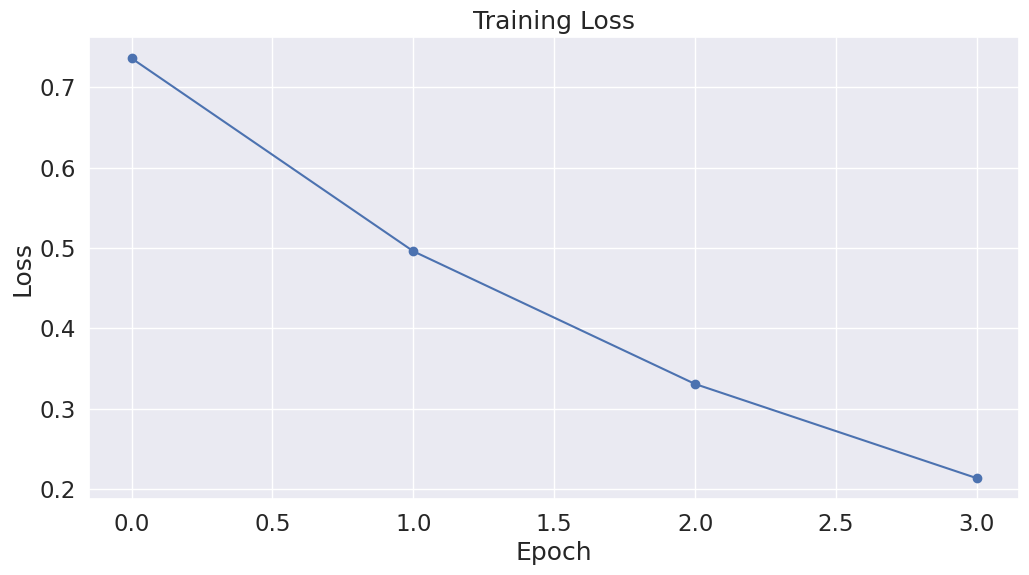

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

Predict and Evaluate the Model

In [ ]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 447 test sentences
 DONE.


In [ ]:
print(test_input[0])

if(prediction[0].any() == 0):
  print("Non Stress Text")
else:
  print("Stress Text")

tensor([  101, 10103, 71265, 10115, 10127, 34641, 10476, 10110, 39854, 10104,
        10487, 11497,   117, 19753,   117, 11817, 14324, 90502, 11210, 17334,
        10103, 13347, 10108, 14008, 45429, 10104, 11309,   119, 10372, 10127,
        10487, 23973, 13524,   119, 11526, 10855, 10320,   143, 14291, 40043,
          113, 10362, 12985, 10453,   114, 10855, 12296, 13168, 10125, 10399,
        10108, 10487, 18683,   117, 38881, 19089, 11359, 10362, 14319,   113,
        10362, 10525, 10110,   151, 10743, 13168, 10855, 10104, 24965, 10171,
        12671, 10488, 10743, 44529, 10855,   114,   119,   111, 55104, 65998,
          132, 23934, 29586, 35591,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.715


In [ ]:
acc = accuracy_score(flat_true_labels, flat_prediction)
print("ACC: %.3f" %acc)


ACC: 0.855


In [ ]:
print(confusion_matrix(flat_true_labels, flat_prediction))

[[186  46]
 [ 19 196]]


In [ ]:
print(classification_report(flat_true_labels, flat_prediction))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       232
           1       0.81      0.91      0.86       215

    accuracy                           0.85       447
   macro avg       0.86      0.86      0.85       447
weighted avg       0.86      0.85      0.85       447

